In [9]:
import pikepdf
import zlib
import sys # Used for error handling, might print instead of exiting in notebook

In [10]:
import fitz  # PyMuPDF
import re
import xml.etree.ElementTree as ET
import io
from PIL import Image
import cairosvg  # You might need to install this: pip install cairosvg

def extract_graph_lines(input_pdf_path, output_pdf_path):
    """
    Extract only the graph line elements from a PDF and create a new PDF with just those lines.
    Uses stroke pattern recognition to identify graph lines.
    
    Args:
        input_pdf_path (str): Path to the input PDF file
        output_pdf_path (str): Path where the output PDF will be saved
    """
    # Open the PDF
    doc = fitz.open(input_pdf_path)
    page = doc[0]  # Assuming we're working with the first page
    
    # Get SVG content from the page
    svg_text = page.get_svg_image(text_as_path=True)
    
    # Parse the SVG
    namespace = {'svg': 'http://www.w3.org/2000/svg'}
    root = ET.fromstring(svg_text)
    
    # Find all path elements in the SVG
    paths = root.findall('.//svg:path', namespace)
    
    # Create a new SVG document to hold our filtered content
    new_svg = ET.Element('svg', {
        'xmlns': 'http://www.w3.org/2000/svg',
        'width': str(page.rect.width),
        'height': str(page.rect.height),
        'viewBox': f"0 0 {page.rect.width} {page.rect.height}"
    })
    
    # Filter paths and add graph lines to new SVG
    for path in paths:
        if is_graph_line(path, namespace):
            new_svg.append(path)
    
    # Convert the new SVG to string
    new_svg_str = ET.tostring(new_svg, encoding='utf-8', method='xml').decode('utf-8')
    
    # Create a new PDF document
    new_doc = fitz.open()
    new_page = new_doc.new_page(width=page.rect.width, height=page.rect.height)
    
    # Method 1: Try to use SVG rendering via Cairo (more reliable)
    try:
        # Convert SVG to PNG using cairosvg
        png_data = cairosvg.svg2png(bytestring=new_svg_str.encode('utf-8'))
        
        # Create an image from the PNG data
        img = fitz.Pixmap(png_data)
        
        # Insert the image into the page
        new_page.insert_image(new_page.rect, pixmap=img)
    except (ImportError, Exception) as e:
        print(f"Cairo rendering failed: {e}, trying alternative method...")
        
        # Method 2: Alternative approach using PIL
        try:
            # Write SVG to temporary file
            import tempfile
            with tempfile.NamedTemporaryFile(suffix='.svg', delete=False) as temp:
                temp_name = temp.name
                temp.write(new_svg_str.encode('utf-8'))
            
            # Use draw_file which is more widely available across PyMuPDF versions
            new_page.draw_file(temp_name, dpi=300)
            
            # Clean up the temporary file
            import os
            os.unlink(temp_name)
        except Exception as e2:
            # Method 3: Last resort - render as PNG with PIL or similar
            print(f"Alternative method failed: {e2}, using basic method...")
            
            # For this backup method, we'll use a simple rect to show where the graph should be
            # Just to ensure we get some output rather than failing completely
            rect = fitz.Rect(0, 0, page.rect.width, page.rect.height)
            new_page.draw_rect(rect, color=(0, 0, 0), width=1)
            
            # Add a text annotation explaining the issue
            new_page.insert_text((50, 50), "Graph rendering failed - see console for details")
    
    # Save the new PDF
    new_doc.save(output_pdf_path)
    new_doc.close()
    doc.close()
    
    print(f"Graph lines extracted and saved to {output_pdf_path}")

def is_graph_line(path_element, namespace):
    """
    Determine if a path element represents a graph line based on stroke pattern.
    
    Args:
        path_element: An XML Element representing an SVG path
        namespace: The SVG namespace dictionary
        
    Returns:
        bool: True if the path appears to be a graph line, False otherwise
    """
    # Get path data
    d = path_element.get('d', '')
    style = path_element.get('style', '')
    
    # Check for line characteristics - scoring approach
    score = 0
    
    # 1. Long continuous paths (not short decorative elements)
    if len(d) > 50:
        score += 1
    
    # 2. Contains mostly linear commands (M, L, H, V)
    commands = re.findall(r'[MLHVCSQTAZmlhvcsqtaz]', d)
    if commands:
        line_commands = [c for c in commands if c.lower() in 'mlhv']
        if len(line_commands) / len(commands) > 0.7:
            score += 2
    
    # 3. Has a stroke style and no or transparent fill
    if 'stroke:' in style and ('fill:none' in style or 'fill:transparent' in style):
        score += 2
    
    # 4. Reasonable stroke width for a graph line
    stroke_width_match = re.search(r'stroke-width:\s*(\d+\.?\d*)', style)
    if stroke_width_match:
        width = float(stroke_width_match.group(1))
        if 0.5 <= width <= 3.0:  # Typical graph line thickness
            score += 1
    
    # 5. Spans significant portion of canvas (analyze coordinates)
    coords = re.findall(r'-?\d+\.?\d*', d)
    if len(coords) >= 4:
        try:
            # Extract x and y coordinates
            x_coords = [float(coords[i]) for i in range(0, len(coords), 2) if i+1 < len(coords)]
            y_coords = [float(coords[i+1]) for i in range(0, len(coords), 2) if i+1 < len(coords)]
            
            if x_coords and y_coords:
                x_range = max(x_coords) - min(x_coords)
                y_range = max(y_coords) - min(y_coords)
                
                # Graph lines typically span significant distance
                if x_range > 100 or y_range > 100:
                    score += 2
                
                # Check for data-like variation in y values
                if len(set(y_coords)) > len(y_coords) * 0.3:  # Some variation in y values
                    score += 1
        except Exception:
            pass  # Skip if there's an error processing the coordinates
    
    # Return True if the path meets enough criteria to be considered a graph line
    return score >= 5  # Threshold can be adjusted based on testing

pdf_path = "/Users/air/Desktop/BSC Projects/PDFconverter/Original PDFs/CENSORED_235224_20200205203012_.pdf"

# Example usage
extract_graph_lines(pdf_path, 'graph_lines_only.pdf')

Graph lines extracted and saved to graph_lines_only.pdf


# Keep only graph lines using low level svg control

In [11]:
'''
import pikepdf
import traceback


def filter_red_grid_lines_fixed(content, red_threshold=0.1):
    """
    Filters out red grid lines from PDF content stream.
    Handles both multi-line and single-line content streams.
    
    Args:
        content (str): The raw PDF content stream
        red_threshold (float): Tolerance for red color detection
    
    Returns:
        tuple: (filtered_content, removed_count)
    """
    # First, try to split by newlines (original approach)
    lines = content.split('\n')
    
    # If we only have one line (or very few), try to tokenize by PDF operators
    if len(lines) <= 2 and len(content.strip()) > 50:
        # Single line content - tokenize by common PDF operators
        content_tokens = tokenize_pdf_content(content.strip())
        return filter_tokens_for_red_grid(content_tokens, red_threshold)
    else:
        # Multi-line content - use original approach
        return filter_multiline_content(lines, red_threshold)

def tokenize_pdf_content(content):
    """
    Tokenize single-line PDF content into meaningful chunks.
    """
    import re
    
    # Split by 'q' and 'Q' to find graphics state blocks
    # Use regex to find q...Q blocks while preserving the delimiters
    blocks = re.split(r'(\bq\b|\bQ\b)', content)
    
    # Reconstruct blocks properly
    result_blocks = []
    current_block = ""
    in_graphics_state = False
    
    for token in blocks:
        token = token.strip()
        if not token:
            continue
            
        if token == 'q':
            if current_block:
                result_blocks.append(current_block.strip())
            current_block = 'q'
            in_graphics_state = True
        elif token == 'Q':
            current_block += ' Q'
            result_blocks.append(current_block.strip())
            current_block = ""
            in_graphics_state = False
        else:
            if in_graphics_state:
                current_block += ' ' + token
            else:
                if current_block:
                    result_blocks.append(current_block.strip())
                current_block = token
    
    if current_block:
        result_blocks.append(current_block.strip())
    
    return result_blocks

def filter_tokens_for_red_grid(content_blocks, red_threshold=0.1):
    """
    Filter content blocks for red grid patterns.
    """
    filtered_blocks = []
    removed_count = 0
    
    for block in content_blocks:
        if block.startswith('q') and block.endswith('Q'):
            # This is a graphics state block - check if it's a red grid
            if is_red_grid_block_single_line(block, red_threshold):
                removed_count += 1
                continue  # Skip this block
        
        filtered_blocks.append(block)
    
    return ' '.join(filtered_blocks), removed_count

def is_red_grid_block_single_line(block_content, red_threshold=0.1):
    """
    Check if a single-line graphics state block contains red grid lines.
    """
    import re
    
    has_red_color = False
    has_line_drawing = False
    has_straight_line = False
    
    # Check for red color pattern in single line
    rgb_match = re.search(r'([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+RG', block_content)
    if rgb_match:
        r, g, b = float(rgb_match.group(1)), float(rgb_match.group(2)), float(rgb_match.group(3))
        if (r > (1.0 - red_threshold) and 
            g < (0.8 + red_threshold) and 
            b < (0.8 + red_threshold)):
            has_red_color = True
    
    # Check for line drawing operations
    if re.search(r'\bS\b|\bs\b', block_content):  # Stroke operations
        has_line_drawing = True
    
    # Check for straight line patterns
    if re.search(r'\d+\s+\d+\s+m.*?\d+\s+\d+\s+l', block_content):  # moveto...lineto
        has_straight_line = True
    
    return has_red_color and has_line_drawing and has_straight_line

def filter_multiline_content(lines, red_threshold=0.1):
    """
    Original multi-line filtering approach.
    """
    filtered_lines = []
    removed_count = 0
    i = 0
    
    while i < len(lines):
        line = lines[i].strip()
        
        if line == 'q':
            block_start = i
            block_end = find_matching_Q(lines, i)
            
            if block_end != -1:
                block_lines = lines[block_start:block_end + 1]
                block_content = '\n'.join(block_lines)
                
                if is_red_grid_block(block_content, red_threshold):
                    removed_count += 1
                    i = block_end + 1
                    continue
                else:
                    filtered_lines.extend(block_lines)
                    i = block_end + 1
            else:
                filtered_lines.append(line)
                i += 1
        else:
            filtered_lines.append(line)
            i += 1
    
    return '\n'.join(filtered_lines), removed_count

# Update the main function to use the fixed filter
def remove_red_grid_lines(input_pdf_path, output_pdf_path, red_threshold=0.1):
    """
    Removes red grid lines (vertical and horizontal) from a single-page PDF.
    Now handles both single-line and multi-line content streams.
    """
    print(f"Removing red grid lines from: {input_pdf_path}")
    
    try:
        with pikepdf.Pdf.open(input_pdf_path) as pdf:
            if not pdf.pages:
                print("ERROR: PDF has no pages")
                return False
            
            page = pdf.pages[0]
            
            if not page.Contents:
                print("WARNING: Page has no Contents stream")
                return False
            
            content_streams = []
            if isinstance(page.Contents, pikepdf.Array):
                content_streams = list(page.Contents)
            elif isinstance(page.Contents, pikepdf.Stream):
                content_streams = [page.Contents]
            else:
                print(f"ERROR: Unexpected Contents type: {type(page.Contents)}")
                return False
            
            modified_streams = []
            total_removed = 0
            
            for i, stream in enumerate(content_streams):
                try:
                    stream_bytes = stream.read_bytes()
                    stream_content = stream_bytes.decode('latin-1', errors='replace')
                    
                    print(f"Processing stream {i}, length: {len(stream_content)} chars")
                    
                    # Use the fixed filter function
                    filtered_content, removed_count = filter_red_grid_lines_fixed(stream_content, red_threshold)
                    total_removed += removed_count
                    
                    print(f"Stream {i}: Removed {removed_count} red grid segments")
                    
                    new_stream = pikepdf.Stream(pdf, filtered_content.encode('latin-1'))
                    modified_streams.append(new_stream)
                    
                except Exception as e:
                    print(f"ERROR processing stream {i}: {e}")
                    return False
            
            if len(modified_streams) == 1:
                page.Contents = modified_streams[0]
            else:
                page.Contents = pikepdf.Array(modified_streams)
            
            pdf.save(output_pdf_path)
            print(f"Successfully removed {total_removed} red grid line segments")
            print(f"Output saved to: {output_pdf_path}")
            return True
            
    except Exception as e:
        print(f"ERROR: Unexpected error occurred: {e}")
        traceback.print_exc()
    
    return False

# Test the function
def test_remove_red_grid():
    input_file = 'CENSORED_148706_18305_20170208231132_(pre-pre-strokke)_censored.pdf'
    output_file = 'output_no_red_grid.pdf'
    
    success = remove_red_grid_lines(input_file, output_file)
    if success:
        print("Red grid lines removed successfully!")
        # Verify by printing content of output
        print("\n=== Checking output file ===")
        print_pdf_content_stream(output_file)
    else:
        print("Failed to remove red grid lines.")

# Run the test
test_remove_red_grid()
'''

<>:102: SyntaxWarning: invalid escape sequence '\d'
<>:102: SyntaxWarning: invalid escape sequence '\d'
/var/folders/r0/xbx31xpj0554br082pwpt4sc0000gn/T/ipykernel_60562/2402029010.py:102: SyntaxWarning: invalid escape sequence '\d'
  rgb_match = re.search(r'([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+RG', block_content)


'\nimport pikepdf\nimport traceback\n\n\ndef filter_red_grid_lines_fixed(content, red_threshold=0.1):\n    """\n    Filters out red grid lines from PDF content stream.\n    Handles both multi-line and single-line content streams.\n\n    Args:\n        content (str): The raw PDF content stream\n        red_threshold (float): Tolerance for red color detection\n\n    Returns:\n        tuple: (filtered_content, removed_count)\n    """\n    # First, try to split by newlines (original approach)\n    lines = content.split(\'\n\')\n\n    # If we only have one line (or very few), try to tokenize by PDF operators\n    if len(lines) <= 2 and len(content.strip()) > 50:\n        # Single line content - tokenize by common PDF operators\n        content_tokens = tokenize_pdf_content(content.strip())\n        return filter_tokens_for_red_grid(content_tokens, red_threshold)\n    else:\n        # Multi-line content - use original approach\n        return filter_multiline_content(lines, red_threshold)\n\

# Extract SVG Data from PDF

Extract embedded SVG data from PDF content streams and save as SVG files

In [22]:
import pikepdf
import xml.etree.ElementTree as ET
import re
import os
import traceback
from xml.dom import minidom

def extract_svg_from_pdf(input_pdf_path, output_svg_path=None, method='direct'):
    """
    Extract SVG data from PDF content streams and save as SVG file.
    
    Args:
        input_pdf_path (str): Path to the input PDF file
        output_svg_path (str): Path for output SVG file (optional)
        method (str): Extraction method - 'direct', 'pymupdf', or 'both'
    
    Returns:
        dict: Results with success status and extracted SVG data
    """
    if output_svg_path is None:
        base_name = os.path.splitext(input_pdf_path)[0]
        output_svg_path = f"{base_name}_extracted.svg"
    
    print(f"=== Extracting SVG from PDF ===")
    print(f"Input: {input_pdf_path}")
    print(f"Output: {output_svg_path}")
    print(f"Method: {method}")
    
    results = {
        'success': False,
        'svg_content': None,
        'method_used': method,
        'streams_found': 0,
        'svg_streams': [],
        'errors': []
    }
    
    try:
        if method in ['direct', 'both']:
            # Method 1: Direct content stream analysis
            direct_result = extract_svg_direct_method(input_pdf_path)
            if direct_result['success']:
                results.update(direct_result)
                write_svg_file(results['svg_content'], output_svg_path)
                results['success'] = True
                return results
        
        if method in ['pymupdf', 'both']:
            # Method 2: PyMuPDF SVG conversion
            pymupdf_result = extract_svg_pymupdf_method(input_pdf_path)
            if pymupdf_result['success']:
                results.update(pymupdf_result)
                write_svg_file(results['svg_content'], output_svg_path)
                results['success'] = True
                return results
        
        if not results['success']:
            print("No SVG data found using any method")
        
        return results
        
    except Exception as e:
        error_msg = f"Error extracting SVG: {e}"
        print(error_msg)
        results['errors'].append(error_msg)
        traceback.print_exc()
        return results

def extract_svg_direct_method(pdf_path):
    """
    Extract SVG by analyzing PDF content streams directly.
    """
    print("\n--- Direct Content Stream Analysis ---")
    
    results = {
        'success': False,
        'svg_content': None,
        'streams_found': 0,
        'svg_streams': []
    }
    
    try:
        with pikepdf.Pdf.open(pdf_path) as pdf:
            # Check all objects for SVG content
            for obj_id, obj in enumerate(pdf.objects):
                if isinstance(obj, pikepdf.Stream):
                    try:
                        stream_data = obj.read_bytes()
                        
                        # Check for XML/SVG indicators
                        svg_indicators = [b'<?xml', b'<svg', b'xmlns="http://www.w3.org/2000/svg"']
                        if any(indicator in stream_data for indicator in svg_indicators):
                            try:
                                decoded = stream_data.decode('utf-8', errors='replace')
                                
                                # Look for SVG content
                                svg_match = re.search(r'<svg[^>]*>.*?</svg>', decoded, re.DOTALL | re.IGNORECASE)
                                if svg_match:
                                    svg_content = svg_match.group(0)
                                    results['svg_streams'].append({
                                        'object_id': f"{obj.objgen[0]},{obj.objgen[1]}",
                                        'content': svg_content,
                                        'length': len(svg_content)
                                    })
                                    
                                    if not results['svg_content']:  # Use first found SVG
                                        results['svg_content'] = svg_content
                                        results['success'] = True
                                
                                # Also check for partial SVG elements
                                elif any(tag in decoded.lower() for tag in ['<path', '<rect', '<circle', '<line']):
                                    # Try to reconstruct SVG from elements
                                    reconstructed = reconstruct_svg_from_elements(decoded)
                                    if reconstructed:
                                        results['svg_streams'].append({
                                            'object_id': f"{obj.objgen[0]},{obj.objgen[1]}",
                                            'content': reconstructed,
                                            'length': len(reconstructed),
                                            'type': 'reconstructed'
                                        })
                                        
                                        if not results['svg_content']:
                                            results['svg_content'] = reconstructed
                                            results['success'] = True
                            
                            except UnicodeDecodeError:
                                # Try latin-1 encoding
                                try:
                                    decoded = stream_data.decode('latin-1', errors='replace')
                                    # Repeat SVG search with latin-1 decoded content
                                    if '<svg' in decoded.lower():
                                        svg_match = re.search(r'<svg[^>]*>.*?</svg>', decoded, re.DOTALL | re.IGNORECASE)
                                        if svg_match:
                                            results['svg_content'] = svg_match.group(0)
                                            results['success'] = True
                                except:
                                    pass
                    
                    except Exception as e:
                        # Skip problematic streams
                        continue
            
            results['streams_found'] = len(results['svg_streams'])
            
            if results['success']:
                print(f"Found {results['streams_found']} SVG-containing streams")
                print(f"Selected SVG content length: {len(results['svg_content'])} characters")
            else:
                print("No direct SVG content found in content streams")
            
            return results
            
    except Exception as e:
        print(f"Error in direct method: {e}")
        return results

def extract_svg_pymupdf_method(pdf_path):
    """
    Extract SVG using PyMuPDF's built-in SVG conversion.
    """
    print("\n--- PyMuPDF SVG Conversion ---")
    
    results = {
        'success': False,
        'svg_content': None
    }
    
    try:
        import fitz  # PyMuPDF
        
        doc = fitz.open(pdf_path)
        page = doc[0]  # Get first page
        
        # Convert page to SVG
        svg_text = page.get_svg_image()
        
        if svg_text and '<svg' in svg_text:
            results['svg_content'] = svg_text
            results['success'] = True
            print(f"Generated SVG from PDF page: {len(svg_text)} characters")
        else:
            print("Failed to generate SVG from page")
        
        doc.close()
        return results
        
    except ImportError:
        print("PyMuPDF not available for SVG conversion")
        return results
    except Exception as e:
        print(f"Error in PyMuPDF method: {e}")
        return results

def reconstruct_svg_from_elements(content):
    """
    Attempt to reconstruct SVG from scattered SVG elements.
    """
    try:
        # Find SVG elements
        svg_elements = []
        
        # Common SVG tags to look for
        svg_tags = ['path', 'rect', 'circle', 'ellipse', 'line', 'polyline', 'polygon', 'text', 'g']
        
        for tag in svg_tags:
            pattern = f'<{tag}[^>]*>.*?</{tag}>'
            matches = re.findall(pattern, content, re.DOTALL | re.IGNORECASE)
            svg_elements.extend(matches)
            
            # Also look for self-closing tags
            pattern = f'<{tag}[^>]*/?>'
            matches = re.findall(pattern, content, re.IGNORECASE)
            svg_elements.extend(matches)
        
        if not svg_elements:
            return None
        
        # Create SVG wrapper
        svg_content = '<?xml version="1.0" encoding="UTF-8"?>\n'
        svg_content += '<svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 800 600">\n'
        
        for element in svg_elements:
            svg_content += '  ' + element + '\n'
        
        svg_content += '</svg>'
        
        return svg_content
        
    except Exception as e:
        print(f"Error reconstructing SVG: {e}")
        return None

def write_svg_file(svg_content, output_path):
    """
    Write SVG content to file with proper formatting.
    """
    try:
        # Pretty print the SVG if possible
        try:
            # Parse and reformat XML
            root = ET.fromstring(svg_content)
            pretty_xml = minidom.parseString(ET.tostring(root)).toprettyxml(indent="  ")
            # Remove empty lines
            pretty_xml = '\n'.join(line for line in pretty_xml.split('\n') if line.strip())
            svg_content = pretty_xml
        except:
            # If parsing fails, use original content
            pass
        
        with open(output_path, 'w', encoding='utf-8') as f:
            f.write(svg_content)
        
        print(f"SVG saved to: {output_path}")
        return True
        
    except Exception as e:
        print(f"Error writing SVG file: {e}")
        return False

# Test the SVG extraction
#test_file = 'CENSORED_235224_20200205203012__censored.pdf'
test_file = "/Users/air/Desktop/BSC Projects/PDFconverter/Original PDFs/CENSORED_235224_20200205203012_.pdf"

#test_file = 'CENSORED_148706_18305_20170208231132_(pre-pre-strokke)_redacted.pdf'
print("=== Testing SVG Extraction ===")

# Try direct method first
result = extract_svg_from_pdf(test_file, method='direct')

if not result['success']:
    print("\nDirect method failed, trying PyMuPDF method...")
    result = extract_svg_from_pdf(test_file, method='pymupdf')

if result['success']:
    print(f"\n✅ SVG extraction successful!")
    print(f"📄 SVG content length: {len(result['svg_content'])} characters")
    if result.get('streams_found'):
        print(f"🔍 Found {result['streams_found']} SVG-containing streams")
else:
    print("\n❌ SVG extraction failed")
    if result['errors']:
        print("Errors:", result['errors'])
        
"""
This code takes a PDF file and extracts SVG content from it using two methods
1. Here I need to take only the PyMuPDF method, its the only one that works reliably across different PDFs.
2. I need to make the function return a temp svg file path instead of saving it directly.


"""

=== Testing SVG Extraction ===
=== Extracting SVG from PDF ===
Input: /Users/air/Desktop/BSC Projects/PDFconverter/Original PDFs/CENSORED_235224_20200205203012_.pdf
Output: /Users/air/Desktop/BSC Projects/PDFconverter/Original PDFs/CENSORED_235224_20200205203012__extracted.svg
Method: direct

--- Direct Content Stream Analysis ---
No direct SVG content found in content streams
No SVG data found using any method

Direct method failed, trying PyMuPDF method...
=== Extracting SVG from PDF ===
Input: /Users/air/Desktop/BSC Projects/PDFconverter/Original PDFs/CENSORED_235224_20200205203012_.pdf
Output: /Users/air/Desktop/BSC Projects/PDFconverter/Original PDFs/CENSORED_235224_20200205203012__extracted.svg
Method: pymupdf

--- PyMuPDF SVG Conversion ---
Generated SVG from PDF page: 373362 characters
SVG saved to: /Users/air/Desktop/BSC Projects/PDFconverter/Original PDFs/CENSORED_235224_20200205203012__extracted.svg

✅ SVG extraction successful!
📄 SVG content length: 373362 characters


'\nThis code takes a PDF file and extracts SVG content from it using two methods\n1. Here I need to take only the PyMuPDF method, its the only one that works reliably across different PDFs.\n2. I need to make the function return a temp svg file path instead of saving it directly.\n'

# Vector graphics extraction from pdf

In [20]:
import xml.etree.ElementTree as ET
import re
import os
from pathlib import Path

def filter_svg_stroke_width_15(svg_file_path, output_file_path=None):
    """
    Filter an SVG file to keep only paths with stroke-width="15".
    These are typically the ECG waveform paths.
    
    Args:
        svg_file_path (str): Path to the input SVG file
        output_file_path (str, optional): Path for output file. If None, adds '_stroke15_only' to filename
    
    Returns:
        dict: Results with success status, filtered content, and statistics
    """
    result = {
        'success': False,
        'svg_content': '',
        'filtered_paths': 0,
        'total_paths': 0,
        'output_path': '',
        'errors': []
    }
    
    try:
        # Check if input file exists
        if not os.path.exists(svg_file_path):
            result['errors'].append(f"Input file not found: {svg_file_path}")
            return result
        
        # Generate output filename if not provided
        if output_file_path is None:
            svg_path = Path(svg_file_path)
            output_file_path = svg_path.parent / f"{svg_path.stem}_stroke15_only{svg_path.suffix}"
        
        result['output_path'] = str(output_file_path)
        
        # Read the SVG file
        with open(svg_file_path, 'r', encoding='utf-8') as f:
            svg_content = f.read()
        
        print(f"📄 Processing: {svg_file_path}")
        print(f"📄 Output will be: {output_file_path}")
        
        # Parse the SVG content
        try:
            root = ET.fromstring(svg_content)
        except ET.ParseError as e:
            result['errors'].append(f"XML parsing error: {e}")
            return result
        
        # Define namespace (if any)
        namespace = {'svg': 'http://www.w3.org/2000/svg'}
        
        # Find all path elements
        paths = root.findall('.//path') + root.findall('.//svg:path', namespace)
        result['total_paths'] = len(paths)
        
        print(f"🔍 Found {result['total_paths']} total paths in SVG")
        
        # Filter paths with stroke-width="15"
        filtered_paths = []
        
        for path in paths:
            stroke_width = path.get('stroke-width')
            style = path.get('style', '')
            
            # Check stroke-width attribute
            is_stroke_15 = stroke_width == '15'
            
            # Also check in style attribute
            if not is_stroke_15 and style:
                style_match = re.search(r'stroke-width\s*:\s*15(?:px|pt|)?(?:;|$)', style)
                is_stroke_15 = style_match is not None
            
            if is_stroke_15:
                filtered_paths.append(path)
                # Print some info about the filtered path
                d_attr = path.get('d', '')[:100] + '...' if len(path.get('d', '')) > 100 else path.get('d', '')
                print(f"  ✅ Keeping path with stroke-width=15: {d_attr}")
        
        result['filtered_paths'] = len(filtered_paths)
        
        if result['filtered_paths'] == 0:
            print("⚠️ No paths with stroke-width='15' found!")
            result['errors'].append("No paths with stroke-width='15' found")
            return result
        
        print(f"🎯 Filtered to {result['filtered_paths']} paths with stroke-width='15'")
        
        # Create new SVG with only filtered paths
        # Create a new root element with same attributes
        new_root = ET.Element(root.tag, root.attrib)
        
        # Copy namespace declarations
        for key, value in root.attrib.items():
            if key.startswith('xmlns'):
                new_root.set(key, value)
        
        # Add filtered paths to new root
        for path in filtered_paths:
            new_root.append(path)
        
        # Convert back to string
        filtered_svg = ET.tostring(new_root, encoding='unicode')
        
        # Add XML declaration
        if not filtered_svg.startswith('<?xml'):
            filtered_svg = '<?xml version="1.0" encoding="UTF-8"?>\n' + filtered_svg
        
        # Pretty format (optional)
        try:
            from xml.dom import minidom
            dom = minidom.parseString(filtered_svg)
            filtered_svg = dom.toprettyxml(indent="  ")
            # Remove empty lines
            filtered_svg = '\n'.join(line for line in filtered_svg.split('\n') if line.strip())
        except:
            pass  # Use unformatted if pretty formatting fails
        
        result['svg_content'] = filtered_svg
        
        # Write filtered SVG to output file
        with open(output_file_path, 'w', encoding='utf-8') as f:
            f.write(filtered_svg)
        
        result['success'] = True
        print(f"✅ Successfully created filtered SVG: {output_file_path}")
        print(f"📊 Statistics: {result['filtered_paths']}/{result['total_paths']} paths kept")
        
    except Exception as e:
        result['errors'].append(f"Unexpected error: {str(e)}")
        print(f"❌ Error filtering SVG: {e}")
    
    return result

def batch_filter_svg_files(directory_path, pattern="*extracted.svg"):
    """
    Batch filter multiple SVG files to extract stroke-width="15" paths.
    
    Args:
        directory_path (str): Directory containing SVG files
        pattern (str): File pattern to match (default: "*extracted.svg")
    
    Returns:
        list: List of results for each processed file
    """
    results = []
    svg_files = list(Path(directory_path).glob(pattern))
    
    if not svg_files:
        print(f"⚠️ No SVG files found matching pattern '{pattern}' in {directory_path}")
        return results
    
    print(f"🔄 Processing {len(svg_files)} SVG files...")
    
    for svg_file in svg_files:
        print(f"\n📄 Processing: {svg_file.name}")
        result = filter_svg_stroke_width_15(str(svg_file))
        result['filename'] = svg_file.name
        results.append(result)
        
        if result['success']:
            print(f"  ✅ Success: {result['filtered_paths']} paths extracted")
        else:
            print(f"  ❌ Failed: {', '.join(result['errors'])}")
    
    # Summary
    successful = sum(1 for r in results if r['success'])
    total_filtered_paths = sum(r['filtered_paths'] for r in results if r['success'])
    
    print(f"\n📊 Batch Summary:")
    print(f"  • Files processed: {len(results)}")
    print(f"  • Successful: {successful}")
    print(f"  • Total ECG paths extracted: {total_filtered_paths}")
    
    return results

# Test the filtering function on extracted SVG files
print("=== Filtering SVG Files for stroke-width='15' paths ===")

# Get current directory
current_dir = os.getcwd()
print(f"Current directory: {current_dir}")

# Look for extracted SVG files
svg_files = list(Path(current_dir).glob("*_extracted.svg"))
print(f"Found {len(svg_files)} extracted SVG files:")
for svg_file in svg_files:
    print(f"  • {svg_file.name}")

if svg_files:
    # Process each SVG file
    for svg_file in svg_files:
        print(f"\n{'='*60}")
        result = filter_svg_stroke_width_15(str(svg_file))
        
        if result['success']:
            print(f"🎉 Successfully filtered {svg_file.name}")
            print(f"📄 Output: {Path(result['output_path']).name}")
            print(f"📊 Extracted {result['filtered_paths']} ECG waveform paths")
        else:
            print(f"❌ Failed to filter {svg_file.name}")
            for error in result['errors']:
                print(f"   Error: {error}")
else:
    print("⚠️ No extracted SVG files found in current directory")
    print("Please make sure SVG extraction has been completed first.")
    

'''
This code takes any svg file and filters it to keep only the paths with stroke-width="15"() the ECG waveform paths.
filter_svg_stroke_width_15 function reads the SVG file, parses it, and filters out paths that do not have a stroke-width of 15. It then writes the filtered SVG content to a new file, which is named by appending "_stroke15_only" to the original filename. 
The function returns a dictionary with the results, including success status, filtered content, and statistics about the number of paths processed.

batch_filter_svg_files function allows you to process multiple SVG files in a directory that match a specified pattern (default is "*extracted.svg"). 
It calls the filter function for each file and collects the results, providing a summary of the processing.

1. filter_svg_stroke_width_15  function needs to take in an temp svg file and return a temp svg file
2. Remove the print statements and replace them with logging

'''

=== Filtering SVG Files for stroke-width='15' paths ===
Current directory: /Users/air/Desktop/BSC Projects/PDFconverter/PDF2JSON
Found 0 extracted SVG files:
⚠️ No extracted SVG files found in current directory
Please make sure SVG extraction has been completed first.


# Signal extraction

-Turn svg graph files into numerical data

## Extract: Convert SVG paths into coordinate points

In [23]:
""" Approach using the matrix transformation and move commands"""

import xml.etree.ElementTree as ET
import numpy as np
import re
from pathlib import Path

def extract_ecg_data_from_svg(svg_file_path):
    """
    Extract ECG waveform data from an SVG file with stroke-width='15' paths.
    
    Args:
        svg_file_path (str): Path to the filtered SVG file
        
    Returns:
        dict: Dictionary of ECG data with lead labels as keys
    """
    # Define path labels in order according to specification
    path_labels = [
        'calibration_1', 'calibration_2', 'calibration_3',
        'I', 'II', 'III', 'aVR', 'aVL', 'aVF',
        'V1', 'V2', 'V3', 'V4', 'V5', 'V6',
        'calibration_4', 'V1_10sec'
    ]
    
    # Initialize results dictionary
    result = {
        'success': False,
        'data': {},
        'errors': [],
        'svg_info': {
            'width': 0,
            'height': 0,
            'viewBox': '',
            'paths_found': 0
        }
    }
    
    try:
        # Parse SVG file
        tree = ET.parse(svg_file_path)
        root = tree.getroot()
        
        # Extract SVG dimensions
        result['svg_info']['width'] = float(root.get('width', 792))
        result['svg_info']['height'] = float(root.get('height', 612))
        result['svg_info']['viewBox'] = root.get('viewBox', '0 0 792 612')
        
        # Find all path elements (handle namespace)
        namespace = {'ns0': 'http://www.w3.org/2000/svg'}
        paths = root.findall('.//ns0:path', namespace)
        
        # If no paths found with namespace, try without namespace
        if not paths:
            paths = root.findall('.//path')
        
        result['svg_info']['paths_found'] = len(paths)
        print(f"Found {len(paths)} paths in SVG file")
        
        # Process each path and assign label based on order
        for i, path in enumerate(paths):
            # Get label for this path based on order
            if i < len(path_labels):
                label = path_labels[i]
            else:
                label = f'unknown_{i+1}'
                
            print(f"Processing path {i+1}: {label}")
            
            # Extract transform matrix
            transform_attr = path.get('transform', '')
            matrix = parse_transform_matrix(transform_attr)
            
            # Extract path data
            d_attr = path.get('d', '')
            if not d_attr:
                print(f"  Warning: Path {i+1} has no 'd' attribute")
                result['errors'].append(f"Path {i+1} ({label}) has no 'd' attribute")
                continue
                
            # Parse path data into points
            points = parse_path_data(d_attr)
            
            # Apply matrix transformation to all points
            transformed_points = apply_transformation(points, matrix)
            
            # Store in result dictionary
            if transformed_points:
                # Separate into x and y arrays
                x_values = [p[0] for p in transformed_points]
                y_values = [p[1] for p in transformed_points]
                
                result['data'][label] = {
                    'x': np.array(x_values),
                    'y': np.array(y_values),
                    'matrix': matrix,
                    'points_count': len(transformed_points)
                }
                
                # Print stats about this lead
                print(f"  ✓ Extracted {len(transformed_points)} points for {label}")
                if len(x_values) > 0:
                    print(f"    X range: {min(x_values):.2f} to {max(x_values):.2f}")
                    print(f"    Y range: {min(y_values):.2f} to {max(y_values):.2f}")
            else:
                print(f"  ✗ No points extracted for {label}")
                result['errors'].append(f"No points extracted for {label}")
        
        result['success'] = True
        
    except Exception as e:
        print(f"Error extracting ECG data: {str(e)}")
        result['errors'].append(f"Error: {str(e)}")
    
    return result

def parse_transform_matrix(transform_str):
    """
    Parse SVG transform matrix attribute.
    
    Args:
        transform_str (str): Transform attribute string like "matrix(a,b,c,d,e,f)"
        
    Returns:
        dict: Matrix components as a dictionary
    """
    matrix = {'a': 1, 'b': 0, 'c': 0, 'd': 1, 'e': 0, 'f': 0}  # Default identity matrix
    
    if not transform_str:
        return matrix
    
    # Extract matrix values using regex
    match = re.search(r'matrix\s*\(\s*([^,]+),\s*([^,]+),\s*([^,]+),\s*([^,]+),\s*([^,]+),\s*([^,)]+)', transform_str)
    
    if match:
        try:
            matrix['a'] = float(match.group(1))  # x scale
            matrix['b'] = float(match.group(2))  # y skew
            matrix['c'] = float(match.group(3))  # x skew
            matrix['d'] = float(match.group(4))  # y scale
            matrix['e'] = float(match.group(5))  # x translation
            matrix['f'] = float(match.group(6))  # y translation
        except ValueError as e:
            print(f"Error parsing matrix values: {e}")
    
    return matrix

def parse_path_data(d_attr):
    """
    Parse SVG path data into a list of coordinate points.
    
    Args:
        d_attr (str): SVG path data string (d attribute)
        
    Returns:
        list: List of (x,y) coordinate tuples
    """
    points = []
    current_x, current_y = 0, 0  # Current position
    
    # Regular expressions to match commands and numbers
    command_regex = re.compile(r'([MLHVZCSQTAmlhvzcsqta])|([-+]?[0-9]*\.?[0-9]+(?:[eE][-+]?[0-9]+)?)')
    
    # Split the path data into tokens (commands and numbers)
    tokens = command_regex.findall(d_attr)
    tokens = [t[0] if t[0] else t[1] for t in tokens if t[0] or t[1]]
    
    i = 0
    current_command = None
    
    while i < len(tokens):
        # Get the current token
        token = tokens[i]
        
        # If it's a command letter, update current_command
        if token.isalpha():
            current_command = token
            i += 1
        # Otherwise it's a number, process according to current command
        elif current_command:
            if current_command in 'Mm':  # Move commands
                if i + 1 < len(tokens):
                    x = float(token)
                    y = float(tokens[i+1])
                    
                    if current_command == 'm':  # Relative
                        current_x += x
                        current_y += y
                    else:  # Absolute
                        current_x = x
                        current_y = y
                    
                    points.append((current_x, current_y))
                    i += 2
                else:
                    i += 1
            
            elif current_command in 'Ll':  # Line commands
                if i + 1 < len(tokens):
                    x = float(token)
                    y = float(tokens[i+1])
                    
                    if current_command == 'l':  # Relative
                        current_x += x
                        current_y += y
                    else:  # Absolute
                        current_x = x
                        current_y = y
                    
                    points.append((current_x, current_y))
                    i += 2
                else:
                    i += 1
            
            elif current_command in 'Hh':  # Horizontal line
                x = float(token)
                
                if current_command == 'h':  # Relative
                    current_x += x
                else:  # Absolute
                    current_x = x
                
                points.append((current_x, current_y))
                i += 1
            
            elif current_command in 'Vv':  # Vertical line
                y = float(token)
                
                if current_command == 'v':  # Relative
                    current_y += y
                else:  # Absolute
                    current_y = y
                
                points.append((current_x, current_y))
                i += 1
            
            else:
                # Skip other commands for now (curves, arcs, etc.)
                i += 1
        else:
            # If we encounter a number without a command, skip it
            i += 1
    
    return points

def apply_transformation(points, matrix):
    """
    Apply SVG matrix transformation to a list of points.
    
    Args:
        points (list): List of (x,y) coordinate tuples
        matrix (dict): Matrix transformation values
        
    Returns:
        list: List of transformed (x,y) coordinate tuples
    """
    transformed_points = []
    
    # unsure if it should be absolute or not 
    #y_scale = abs(matrix['d'])
    
    for x, y in points:
        # Apply the matrix transformation: [a c e] [x]
        #                                 [b d f] [y]
        #                                 [0 0 1] [1]
        new_x = matrix['a'] * x + matrix['c'] * y + matrix['e']
        # Use absolute value of y scale while preserving the sign of any y-skew
        new_y = matrix['b'] * x + matrix['d'] * y + matrix['f']
        transformed_points.append((new_x, new_y))
    
    return transformed_points

# Example usage (without plotting)
svg_file = "CENSORED_235224_20200205203012__censored_extracted_stroke15_only.svg"

if Path(svg_file).exists():
    print(f"Processing SVG file: {svg_file}")
    ecg_data = extract_ecg_data_from_svg(svg_file)
    
    if ecg_data['success']:
        print("\nECG Data Summary:")
        print(f"Total leads extracted: {len(ecg_data['data'])}")
        
        for lead, data in ecg_data['data'].items():
            print(f"  {lead}: {data['points_count']} points")
        
        # Example of how to access specific lead data
        if 'II' in ecg_data['data']:
            lead_II = ecg_data['data']['II']
            print("\nLead II Sample Data (first 5 points):")
            for i in range(min(5, len(lead_II['x']))):
                print(f"  Point {i+1}: ({lead_II['x'][i]:.2f}, {lead_II['y'][i]:.2f})")
    else:
        print("Failed to extract ECG data:")
        for error in ecg_data['errors']:
            print(f"  - {error}")
else:
    print(f"SVG file not found: {svg_file}")
    print("Please run filter_svg_stroke_width_15 function first to generate the SVG file.")
    
"""
This code takes a filtered SVG file (with only paths having stroke-width='15') and turns it into  numerical data.


"""


SVG file not found: CENSORED_235224_20200205203012__censored_extracted_stroke15_only.svg
Please run filter_svg_stroke_width_15 function first to generate the SVG file.


'\n\n'

## Extraction: Visually check plots

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

def plot_ecg_leads_custom_layout(ecg_data, figsize=(15, 12)):
    """
    Plot ECG leads in a specific custom layout:
    Row 1: calibration_1, I, aVR, V1, V4
    Row 2: calibration_2, II, aVL, V2, V5
    Row 3: calibration_3, III, aVF, V3, V6
    Row 4: calibration_4, V1_10sec, (empty), (empty), (empty)
    
    Args:
        ecg_data (dict): ECG data dictionary returned by extract_ecg_data_from_svg
        figsize (tuple): Figure size
    """
    if not ecg_data['success'] or not ecg_data['data']:
        print("No ECG data to plot")
        return
    
    # Define the specific layout
    layout = [
        ['calibration_1', 'I', 'aVR', 'V1', 'V4'],
        ['calibration_2', 'II', 'aVL', 'V2', 'V5'],
        ['calibration_3', 'III', 'aVF', 'V3', 'V6'],
        ['calibration_4', 'V1_10sec', None, None, None]
    ]
    
    # Create the figure and axes
    fig, axs = plt.subplots(4, 5, figsize=figsize)
    
    # Plot each lead in its specified position
    for row_idx, row in enumerate(layout):
        for col_idx, lead in enumerate(row):
            ax = axs[row_idx, col_idx]
            
            if lead is None:
                # Empty plot
                ax.axis('off')
                continue
                
            if lead in ecg_data['data']:
                lead_data = ecg_data['data'][lead]
                ax.plot(lead_data['x'], lead_data['y'])
                ax.set_title(lead)
                ax.grid(True)
            else:
                ax.text(0.5, 0.5, f"Missing: {lead}", 
                       horizontalalignment='center',
                       verticalalignment='center',
                       transform=ax.transAxes)
                ax.set_title(f"{lead} (not found)")
                ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# Example usage (assuming ecg_data is available from the previous cell)
svg_file = "CENSORED_235224_20200205203012__censored_extracted_stroke15_only.svg"

if Path(svg_file).exists() and 'ecg_data' in globals() and ecg_data['success']:
    print("Plotting ECG leads in custom layout...")
    plot_ecg_leads_custom_layout(ecg_data)
else:
    print("ECG data not available. Run the data extraction cell first.")

ECG data not available. Run the data extraction cell first.


# Calibration

In [16]:
""" Print the ECG data in a readable format"""
import numpy as np

# Define the order in which to print the leads
lead_order = [
    ['calibration_1', 'I', 'aVR', 'V1', 'V4'],
    ['calibration_2', 'II', 'aVL', 'V2', 'V5'],
    ['calibration_3', 'III', 'aVF', 'V3', 'V6'],
    ['calibration_4', 'V1_10sec'] 
]

# For each lead, print the name along with stats for x and y arrays
for row in lead_order:
    for lead in row:
        if lead in ecg_data['data']:
            data = ecg_data['data'][lead]
            x_arr = data['x']
            y_arr = data['y']
            print(f"{lead}:")
            print(f"  Points: {len(x_arr)}")
            print(f"  X: min {np.min(x_arr):.2f}, max {np.max(x_arr):.2f}")
            print(f"  Y: min {np.min(y_arr):.2f}, max {np.max(y_arr):.2f}")
        else:
            print(f"{lead}: Data not found")

NameError: name 'ecg_data' is not defined

## Calibration: Get calibration values

In [ ]:
def get_calibration(ecg_data):
    """
    Extracts the minimum and maximum Y values from each calibration wave
    in the ECG data (from extract_ecg_data_from_svg).

    Args:
        ecg_data (dict): Dictionary returned by extract_ecg_data_from_svg with key 'data'.

    Returns:
        dict: Dictionary mapping each calibration key to a tuple (min_y, max_y)
    """
    import numpy as np

    calibration_keys = ["calibration_1", "calibration_2", "calibration_3", "calibration_4"]
    results = {}
    
    for key in calibration_keys:
        if key not in ecg_data.get('data', {}):
            print(f"{key}: Data not found")
            continue
        
        data = ecg_data['data'][key]
        y_arr = data['y']
        
        min_y = np.min(y_arr)
        max_y = np.max(y_arr)
        
        results[key] = (min_y, max_y)
        
        print(f"{key}:")
        print(f"  Y values: min = {min_y:.2f}, max = {max_y:.2f}")
    
    return results

# Example usage:
# Assuming ecg_data is a variable that holds the output dict from extract_ecg_data_from_svg
calibration_results = get_calibration(ecg_data)

calibration_1:
  Y values: min = 179.89, max = 208.24
calibration_2:
  Y values: min = 284.70, max = 313.05
calibration_3:
  Y values: min = 389.51, max = 417.86
calibration_4:
  Y values: min = 494.35, max = 522.70


## Calibration: Normalise amplitude values

In [ ]:
""" Set to mV """
def apply_calibration_to_leads(ecg_data, calibration):
    """
    Applies calibration to lead waves to convert raw y values into mV.
    
    For calibration, the y max value (from calibration) represents 0 mV and 
    the y min represents 1 mV. Thus, for a lead sample y, the conversion is:
        mV = (cal_max - y) / (cal_max - cal_min)
    
    The calibration groups are defined as:
      - Calibration 1 (from calibration_1): applies to leads 'I', 'aVR', 'V1', 'V4'
      - Calibration 2 (from calibration_2): applies to leads 'II', 'aVL', 'V2', 'V5'
      - Calibration 3 (from calibration_3): applies to leads 'III', 'aVF', 'V3', 'V6'
      - Calibration 4 (from calibration_4): applies to lead 'V1_10sec'
    
    Args:
        ecg_data (dict): Dictionary returned by extract_ecg_data_from_svg with key 'data'
        calibration (dict): Dictionary from get_calibration mapping calibration keys to (min_y, max_y)
    
    Returns:
        dict: A dictionary mapping each lead key to a 1D numpy array of calibrated mV values.
    """
    import numpy as np

    # Define the calibration mapping for each lead
    cal_mapping = {
        'calibration_1': ['I', 'aVR', 'V1', 'V4'],
        'calibration_2': ['II', 'aVL', 'V2', 'V5'],
        'calibration_3': ['III', 'aVF', 'V3', 'V6'],
        'calibration_4': ['V1_10sec']
    }
    
    calibrated_leads = {}
    
    for cal_key, leads in cal_mapping.items():
        if cal_key not in calibration:
            print(f"Calibration data not found for {cal_key}. Skipping its leads.")
            continue
        
        cal_min, cal_max = calibration[cal_key]
        amp = cal_max - cal_min
        if amp == 0:
            print(f"Warning: Zero amplitude for {cal_key}. Skipping its leads.")
            continue
        
        for lead in leads:
            if lead not in ecg_data.get('data', {}):
                print(f"Lead {lead} not found in ECG data.")
                continue
            
            # Get raw y values (assumed to be a numpy array)
            y_raw = ecg_data['data'][lead]['y']
            # Apply calibration: y value equal to cal_max gives 0 mV,
            # and y equal to cal_min gives 1 mV.
            mV_values = (cal_max - y_raw) / amp
            calibrated_leads[lead] = mV_values
            print(f"Calibrated lead {lead}: {len(mV_values)} points transformed.")
    
    return calibrated_leads

# Example usage:
# Assuming ecg_data is provided by extract_ecg_data_from_svg and calibration_results by get_calibration
calibrated_data = apply_calibration_to_leads(ecg_data, calibration_results)

Calibrated lead I: 1238 points transformed.
Calibrated lead aVR: 1238 points transformed.
Calibrated lead V1: 1238 points transformed.
Calibrated lead V4: 1238 points transformed.
Calibrated lead II: 1238 points transformed.
Calibrated lead aVL: 1238 points transformed.
Calibrated lead V2: 1238 points transformed.
Calibrated lead V5: 1238 points transformed.
Calibrated lead III: 1238 points transformed.
Calibrated lead aVF: 1238 points transformed.
Calibrated lead V3: 1238 points transformed.
Calibrated lead V6: 1238 points transformed.
Calibrated lead V1_10sec: 5000 points transformed.


## Calibration: Set to desired output frequency

In [ ]:

from scipy.signal import resample

def resample_ecg_leads(calibrated_data, output_fs=300):
    """
    Resample each calibrated ECG lead using Fourier resampling.
    
    For each lead:
      - If lead == 'V1_10sec', recording duration is 10 seconds.
      - Otherwise, recording duration is 2.44 seconds.
    
    Args:
        calibrated_data (dict): Dictionary mapping lead names to 1D numpy arrays.
        output_fs (int): Desired output sampling frequency (in Hz), default 300.
    
    Returns:
        tuple: (resampled_data, durations) where
            resampled_data (dict): Dictionary with resampled data.
            durations (dict): Dictionary mapping lead names to their recording durations.
    """
    resampled = {}
    durations = {}
    for lead, data in calibrated_data.items():
        if lead == 'V1_10sec':
            dur = 10.0
        else:
            dur = 2.44
        durations[lead] = dur
        target_samples = int(output_fs * dur)
        # Use Fourier resampling to compute target_samples from current data
        resampled_data = resample(data, target_samples)
        resampled[lead] = resampled_data
        print(f"Lead {lead}: original {len(data)} pts -> resampled to {target_samples} pts (duration {dur}s)")
    return resampled, durations

resampled_data, lead_durations = resample_ecg_leads(calibrated_data, output_fs=300)

Lead I: original 1238 pts -> resampled to 732 pts (duration 2.44s)
Lead aVR: original 1238 pts -> resampled to 732 pts (duration 2.44s)
Lead V1: original 1238 pts -> resampled to 732 pts (duration 2.44s)
Lead V4: original 1238 pts -> resampled to 732 pts (duration 2.44s)
Lead II: original 1238 pts -> resampled to 732 pts (duration 2.44s)
Lead aVL: original 1238 pts -> resampled to 732 pts (duration 2.44s)
Lead V2: original 1238 pts -> resampled to 732 pts (duration 2.44s)
Lead V5: original 1238 pts -> resampled to 732 pts (duration 2.44s)
Lead III: original 1238 pts -> resampled to 732 pts (duration 2.44s)
Lead aVF: original 1238 pts -> resampled to 732 pts (duration 2.44s)
Lead V3: original 1238 pts -> resampled to 732 pts (duration 2.44s)
Lead V6: original 1238 pts -> resampled to 732 pts (duration 2.44s)
Lead V1_10sec: original 5000 pts -> resampled to 3000 pts (duration 10.0s)


# Final Visual validation plots 

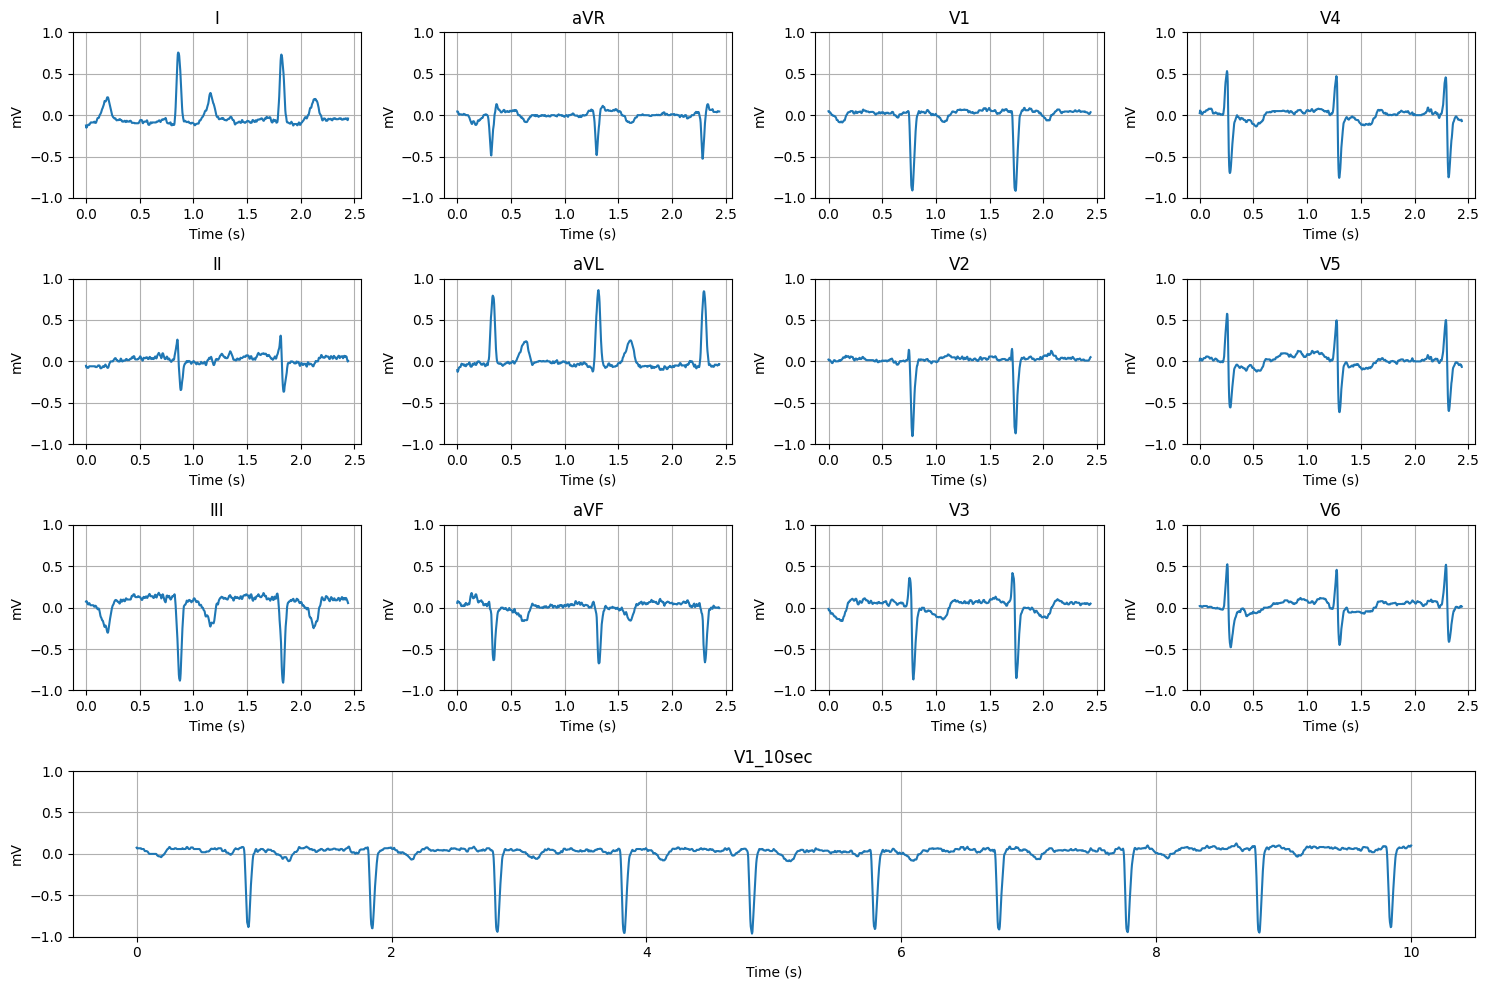

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

def plot_resampled_ecgs(resampled_data, durations, figsize=(15, 10)):
    """
    Plot the resampled ECG leads using a custom layout.
    
    Layout:
      - Rows 1–3: 4 leads per row:
            Row 1: ['I', 'aVR', 'V1', 'V4']
            Row 2: ['II', 'aVL', 'V2', 'V5']
            Row 3: ['III', 'aVF', 'V3', 'V6']
      - Row 4: 'V1_10sec' spans all 4 columns.
    
    The x-axis is the time axis (in seconds) computed from duration for each lead.
    
    Args:
        resampled_data (dict): Dictionary mapping lead names to 1D numpy arrays (resampled).
        durations (dict): Dictionary mapping lead names to recording durations in seconds.
        figsize (tuple): Figure size.
    """
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(4, 4, height_ratios=[1, 1, 1, 1])
    groups = [
        ['I', 'aVR', 'V1', 'V4'],
        ['II', 'aVL', 'V2', 'V5'],
        ['III', 'aVF', 'V3', 'V6']
    ]
    
    # Plot first three rows
    for i, group in enumerate(groups):
        for j, lead in enumerate(group):
            ax = fig.add_subplot(gs[i, j])
            if lead in resampled_data:
                data = resampled_data[lead]
                dur = durations.get(lead, 2.44)
                t = np.linspace(0, dur, len(data))
                ax.plot(t, data)
                ax.set_xlabel("Time (s)")
                ax.set_title(lead)
                ax.set_ylabel("mV")
                ax.grid(True)
                ax.set_ylim(-1, 1)
            else:
                ax.text(0.5, 0.5, f"{lead}\nData not found", 
                        horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
                ax.axis('off')
    
    # Fourth row: V1_10sec spans all 4 columns
    ax = fig.add_subplot(gs[3, :])
    lead = 'V1_10sec'
    if lead in resampled_data:
        data = resampled_data[lead]
        dur = durations.get(lead, 10.0)
        t = np.linspace(0, dur, len(data))
        ax.plot(t, data)
        ax.set_xlabel("Time (s)")
        ax.set_title(lead)
        ax.set_ylabel("mV")
        ax.grid(True)
        ax.set_ylim(-1, 1)
    else:
        ax.text(0.5, 0.5, f"{lead}\nData not found",
                horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()




plot_resampled_ecgs(resampled_data, lead_durations)

## Get text from the pdf

In [27]:

from pdf2image import convert_from_path
from PIL import Image
import pytesseract
import tempfile 

def pdf_to_temp_image(pdf_path, dpi=300):
    """
    Converts the first page of the given PDF into an image at the specified dpi.
    Displays the image and returns it.
    
    Args:
        pdf_path (str): The path to the PDF file.
        dpi (int): The resolution for conversion.
    
    Returns:
        PIL.Image.Image: The converted image.
    """
    images = convert_from_path(pdf_path, dpi=dpi)
    if not images:
        raise ValueError("No images were generated from the PDF.")
    
    im = images[0]
    im.show()  # display the image
    
    # Currently, the function returns the image object itself.
    return im

def get_text_OCR(pdf_path, sections_coordinates, dpi=300):
    """
    Extracts text from specified regions of a PDF file using OCR.
    
    This function converts the PDF to an image via pdf_to_temp_image, then
    for each section defined in sections_coordinates (each given as two coordinate pairs),
    it computes the bounding rectangle (i.e. (left, top, right, bottom)), crops that region,
    and runs OCR.
    
    Args:
        pdf_path (str): Path to the PDF file.
        sections_coordinates (dict): Dictionary mapping section names to coordinates.
            Each value should be a tuple of two tuples: ((x1, y1), (x2, y2)).
            These two coordinates determine the bounding rectangle.
        dpi (int): Resolution for PDF-to-image conversion.
        
    Returns:
        dict: Mapping from section names to the extracted text.
    
    Requirements:
        - pytesseract must be installed.
        - Tesseract OCR must be installed on your system.
    """
    # Convert PDF to image using the existing pdf_to_temp_image function
    im = pdf_to_temp_image(pdf_path, dpi=dpi)
    extracted_text = {}
    
    for section, coords in sections_coordinates.items():
        if len(coords) == 2:
            (x1, y1), (x2, y2) = coords
            left = min(x1, x2)
            top = min(y1, y2)
            right = max(x1, x2)
            bottom = max(y1, y2)
            box = (left, top, right, bottom)
        elif len(coords) == 4:
            box = coords
        else:
            print(f"Invalid coordinates provided for section '{section}': {coords}")
            extracted_text[section] = ""
            continue
        
        # Crop the region from the image
        region = im.crop(box)
        # Run OCR on the cropped region
        text = pytesseract.image_to_string(region)
        extracted_text[section] = text.strip()
    
    return extracted_text

# Example usage with the existing coordinates
sections = {
    "muestra-fecha": ((1292, 88), (1826, 149)),
    "genero-edad": (( 32  , 329 ),( 442  , 394 )),
    "Tasa-vent(LPM)": ((1099, 166), (1199, 212)),
    "Intervalo-Pr(ms)": ((1122, 211), (1191, 251)),
    "Duracion-QRS(ms)": ((1095, 248), (1193, 290)),
    "QT/QTc(ms)": ((1187, 329), (1032, 287)),
    "Ejes-P-R-T": ((1028, 328), (1318, 377)),
    "Diagnosis": ((1388, 170), (3166 ,585 )),
    "Indic.-prueba": ((610, 520), (1327, 566)),
    "Confirmado": ((2237, 580), (2577, 651)),
    "ECG-units": ((37, 2373), (1100, 2432))
}

# Use the path to your PDF file
pdf_path = "/Users/air/Desktop/BSC Projects/PDFconverter/ECG_censored_correct/SPBS-1033_001_20180715194620__censored.pdf"

# Extract text using OCR
ocr_results = get_text_OCR(pdf_path, sections)
print("OCR Results:")
print(ocr_results)

OCR Results:
{'muestra-fecha': '15-JUL-2018 19:46:20', 'genero-edad': 'Masculino (78 afios)', 'Tasa-vent(LPM)': '64', 'Intervalo-Pr(ms)': '02', 'Duracion-QRS(ms)': '182', 'QT/QTc(ms)': '464/478', 'Ejes-P-R-T': '25\n\n-45\n\n48', 'Diagnosis': 'Ritmo sinusal esporddicamente con complejos ventriculares prematuros\n\nBloqueo de la rama derecha\n\nBloqueo fascicular izquierdo anterior\n\n*** Bloqueo bifascicular ***\n\nCriterio de voltaje moderado para hipertrofia ventricular izquierda, puede ser normal\nNo se puede excluir Infarto septal , edad indeterminada\n\nAnomalia de la onda T, considerar isquemia lateral\n\nECG andémalo\n\nNo se dispone de ECG anterior', 'Indic.-prueba': '', 'Confirmado': 'No confirmado', 'ECG-units': '25mm/s 10mm/mV 40Hz 9.0.7. 12SL 241 HD CID: 12'}


# Output as Json

In [17]:
import json
import numpy as np
import matplotlib.pyplot as plt

def create_ecg_json(resampled_data, lead_durations, ocr_results):
    """
    Combines ECG waveform data and text data into a standardized JSON format.
    
    Args:
        resampled_data (dict): Dictionary of resampled lead data
        lead_durations (dict): Dictionary of lead durations in seconds
        ocr_results (dict): Dictionary of OCR text extraction results
        
    Returns:
        str: JSON-formatted string representing the ECG report
    """
    # Add diagnostic prints to check data uniqueness
    print("\n=== DIAGNOSTIC: Checking resampled_data for uniqueness ===")
    for lead, data in resampled_data.items():
        print(f"  {lead}: {len(data)} samples, min={np.min(data):.4f}, max={np.max(data):.4f}")
    print("=== END DIAGNOSTIC ===\n")
    
    # Calculate sampling rate for each lead
    sampling_rates = {lead: len(data)/lead_durations[lead] for lead, data in resampled_data.items()}
    
    # Create the text metadata section
    metadata = {
        "muestra-fecha": ocr_results.get("muestra-fecha", ""),
        "Tasa-vent(LPM)": ocr_results.get("Tasa-vent(LPM)", ""),
        "Intervalo-Pr(ms)": ocr_results.get("Intervalo-Pr(ms)", ""),
        "Duracion-QRS(ms)": ocr_results.get("Duracion-QRS(ms)", ""),
        "QT/QTc(ms)": ocr_results.get("QT/QTc(ms)", ""),
        "Ejes-P-R-T": ocr_results.get("Ejes-P-R-T", ""),
        "Diagnosis": ocr_results.get("Diagnosis", ""),
        "Indic.-prueba": ocr_results.get("Indic.-prueba", ""),
        "Confirmado": ocr_results.get("Confirmado", ""),
        "ECG-units": ocr_results.get("ECG-units", "")
    }
    
    # Create the lead data section
    lead_data = {}
    for lead, data in resampled_data.items():
        # Create time array based on duration and number of samples
        duration = lead_durations[lead]
        time_values = np.linspace(0, duration, len(data)).tolist()
        
        # Make a deep copy of the data to ensure we have unique arrays
        # This fixes the issue where all leads have the same data in the JSON
        amplitude_data = np.copy(data).tolist()
        
        lead_data[lead] = {
            "duration_seconds": duration,
            "sampling_rate_hz": sampling_rates[lead],
            "num_samples": len(data),
            "time_values": time_values,
            "amplitude_mv": amplitude_data  # Use the copied data
        }
        
        # Verify the copied data matches original data
        print(f"Lead {lead}: First 3 values: {amplitude_data[:3]}")
   
    # Combine both sections
    ecg_report = {
        "metadata": metadata,
        "leads": lead_data
    }
    
    # Convert to JSON string with indentation for readability
    json_str = json.dumps(ecg_report, indent=2)
    
    return json_str

# Example usage
if 'resampled_data' in globals() and 'lead_durations' in globals() and 'ocr_results' in globals():
    json_output = create_ecg_json(resampled_data, lead_durations, ocr_results)
    print("ECG JSON Output:")
    print(json_output)
else:
    print("Required data not available. Make sure to run the resampling and OCR extraction cells first.")

Required data not available. Make sure to run the resampling and OCR extraction cells first.
